In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
import numpy as np
import tensorflow
import keras
import os
import cv2
from keras.layers import LeakyReLU
from google.colab.patches import cv2_imshow
from PIL import Image
from keras.models import Model, Sequential
from keras.layers import BatchNormalization, AveragePooling2D
from keras.layers import TimeDistributed
from random import randint
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Concatenate
from keras.layers import MaxPooling2D
from sklearn.model_selection import train_test_split

In [ ]:
trg_data_root = "/content/drive/MyDrive/Datasets/KTH_Video/"
img_rows = 150
img_cols = 150
maxToAdd = 30
nb_classes = 6
class_labels = ["boxing", "handclapping", "handwaving", "jogging", "running", "walking"]

In [ ]:
optimizer = tensorflow.keras.optimizers.Adam()

In [ ]:
def load_data_for_persons(root_folder, start_index, finish_index, frames_per_clip):
    class_labels = ["boxing", "handclapping", "handwaving", "jogging", "running", "walking"] # 6 labels
    frame_path = "/frames/"
    frame_set_prefix = "person"
    rec_prefix = "d"
    rec_count = 4

    data_array = []
    classes_array = []

    for i in range(0, len(class_labels)):
        # class
        class_folder = trg_data_root + class_labels[i] + frame_path
        for j in range(start_index, finish_index+1):
            # person
            if j<10:
                person_folder = class_folder + frame_set_prefix + "0" + str(j) + "_" + class_labels[i] + "_"
            else:
                person_folder = class_folder + frame_set_prefix + str(j) + "_" + class_labels[i] + "_"

            for k in range(1,rec_count+1):
                # recording
                rec_folder = person_folder + rec_prefix + str(k) + "/"
                file_list = [f for f in os.listdir(rec_folder)]
                example_size = len(file_list)

                clip_start_index = 0

                for n in range(clip_start_index,(frames_per_clip+clip_start_index)):
                    file_path = rec_folder + file_list[n]
                    data = np.array( Image.open( file_path), dtype='uint8' )
                    data = cv2.resize(data, (img_cols,img_rows), interpolation = cv2.INTER_AREA)
                    data = data/255.0

                    data_array.append(data)
                    classes_array.append(i)

                print("class_label " + file_path + " is done")

    classes_one_hot = np.zeros((len(classes_array), len(class_labels)))
    classes_one_hot[np.arange(len(classes_array)), classes_array] = 1

    x_train, x_test, Y_train, Y_test = train_test_split(np.array(data_array), classes_one_hot, test_size = 0.2, shuffle = True, random_state = 42)

    print("the ytrain length is : ", classes_one_hot.shape)
    # done

    return (x_train, x_test, Y_train, Y_test)

In [ ]:
print ("Loading data")
# load training data
x_train, x_test, Y_train, Y_test  = load_data_for_persons(trg_data_root, 1, 25, maxToAdd)
print("loading is done")

In [ ]:
print("length of x_train : ", len(x_train))
print("length of Y_train : ", len(Y_train))
print("length of x_test : ", len(x_test))
print("length of Y_test : ", len(Y_test))
print("shape of x_train : ", x_train[0].shape)
print("shape of x_train : ", Y_train[0].shape)


length of x_train :  14400
length of Y_train :  14400
length of x_test :  3600
length of Y_test :  3600
shape of x_train :  (150, 150, 3)
shape of x_train :  (6,)


In [ ]:
inputlayer = Input(shape = (img_rows,img_cols,3), batch_size = 20)

In [ ]:
import tensorflow as tf

def basic_Conv(x, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
    conv = Conv2D(out_planes, kernel_size=kernel_size, strides=stride, padding=padding, dilation_rate=dilation, groups=groups, use_bias=bias)(x)
    if bn:
        conv = BatchNormalization(epsilon=1e-5, momentum=0.01, trainable=True)(conv)
    if relu:
        conv = Activation("relu")(conv)
    return conv

def channelPooling(x):
    max_pool = tf.reduce_max(x, axis=3, keepdims=True)
    mean_pool = tf.reduce_mean(x, axis=3, keepdims=True)
    return tf.concat([max_pool, mean_pool], axis=3)

def spatial_attention(x):
  x_compress = channelPooling(x)
  x_out = basic_Conv(x_compress, 2, 1, kernel_size, stride=1, padding="same", relu=False)
  scale = tf.sigmoid(x_out)
  output_tensor = Multiply()([x, scale])
  return output_tensor

In [ ]:
X = spatial_attention(inputlayer)
pretrained_model = tf.keras.applications.MobileNet(include_top=False, input_shape=(img_rows, img_cols, 3), pooling=None, weights= None)
new_model = Model(inputs=pretrained_model.input, outputs=out_layer)

X_out = new_model(X)
X_out = AveragePooling2D(pool_size=(2, 2))(X_out)
X_out = Flatten()(X_out)

X = Convolution2D(16, (3, 3), strides = (1,1),padding = "valid")(X)
X = BatchNormalization()(X)
X = LeakyReLU(alpha = 0.1)(X)
X = MaxPooling2D(pool_size=(2, 2))(X)

X = Convolution2D(64, (3, 3), strides = (1,1),padding = "valid")(X)
X = BatchNormalization()(X)
X = LeakyReLU(alpha = 0.1)(X)
X = MaxPooling2D(pool_size=(2, 2))(X)

X = Convolution2D(128, (1, 1), strides = (1,1),padding = "valid")(X)
X = BatchNormalization()(X)
X = LeakyReLU(alpha = 0.1)(X)
X = MaxPooling2D(pool_size=(2, 2))(X)
X = Flatten()(X)

X_output = Concatenate()([X_out, X])

In [ ]:
def channelPoolingTemporal(x):
    max_pool = tf.reduce_max(x, axis=2, keepdims=True)
    mean_pool = tf.reduce_mean(x, axis=2, keepdims=True)
    return tf.concat([max_pool, mean_pool], axis=2)

def TemporalAttention(x):
    x = tf.reduce_mean(x, axis=1)
    x_compress = channelPoolingTemporal(x)
    y = LSTM(units=units, return_sequences=True)(x_compress)
    attention_weights = Dense(1, activation='sigmoid')(y)
    output_tensor = Multiply()([x, attention_weights])
    return output_tensor

In [ ]:
leaky = LeakyReLU(0.1)
def residual_block(x, dilation_rate, nb_filters, kernel_size, padding, activation, dropout_rate=0):
    prev_x = x
    x = Conv1D(filters=nb_filters[0], kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    x = Conv1D(filters=nb_filters[1], kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    prev_x = Conv1D(nb_filters[1], 1, padding='same')(prev_x)
    res_x = keras.layers.add([prev_x, x])
    res_x = Activation(activation)(res_x)
    return res_x, x

def process_dilations(dilations):
    def is_power_of_two(num):
        return num != 0 and ((num & (num - 1)) == 0)

    if all([is_power_of_two(i) for i in dilations]):
        return dilations

    else:
        new_dilations = [2 ** i for i in dilations]
        return new_dilations
class TCN:
    def __init__(self, nb_filters = nb_filters, kernel_size=kernel_size, nb_stacks=1, dilations=[1, 2, 4, 8], padding='causal', use_skip_connections=True, dropout_rate=0.0, return_sequences=False):
        self.name = name
        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.activation = activation
        self.padding = padding

    def __call__(self, inputs):
        x = inputs
        x = Convolution1D(self.nb_filters[0], 1, padding=self.padding)(x)
        skip_connections = []
        for s in range(self.nb_stacks):
            for d in self.dilations:
                x, skip_out = residual_block(x, dilation_rate=d, nb_filters=self.nb_filters, kernel_size=self.kernel_size, padding=self.padding, activation=self.activation, dropout_rate=self.dropout_rate)
                skip_connections.append(skip_out)
        return x

class TemporalFeaturesExtraction:
    def __init__(self, nb_filters, kernel_size, dilations, nb_stacks, max_len, padding='causal', use_skip_connections=True, return_sequences=True, dropout_rate=0.5):
        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.max_len = max_len
        self.padding = padding
        self.use_skip_connections = use_skip_connections
        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate

    def __call__(self, inputs):
        in_features = inputs
        dilations = process_dilations(self.dilations)
        features_temporal = TCN(self.nb_filters, self.kernel_size, self.nb_stacks, dilations, self.padding, self.use_skip_connections, self.dropout_rate, self.return_sequences)(in_features)

        return features_temporal

In [ ]:
Y = TemporalAttention(inputlayer)
Y_temporal = TemporalFeaturesExtraction(nb_filters, kernel_size = kernel_size, dilations = [1, 2, 4, 8], max_len = img_rows)(Y)
Y_output = Flatten()(Y_temporal)

In [ ]:
fusion_output = Concatenate()([X_output, Y_output])

In [ ]:
fusion_dense = Dense(256,kernel_regularizer=tf.keras.regularizers.l2(0.01))(fusion_output)
fusion_dense = LeakyReLU(0.1)(fusion_dense)
fusion_dense =Dropout(0.2)(fusion_dense)
fusion_dense = Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.01))(fusion_dense)
fusion_dense = LeakyReLU(0.1)(fusion_dense)
fusion_dense = Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01))(fusion_dense)
fusion_dense = LeakyReLU(0.1)(fusion_dense)
final_output = Dense(nb_classes, activation='softmax')(fusion_dense)
model_final = Model(inputs = inputlayer, outputs = final_output)

model_final.compile(optimizer = "RMSProp", loss = "categorical_crossentropy", metrics = 'accuracy')
model_final.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(20, 150, 150, 3)]          0         []                            
                                                                                                  
 tf.math.reduce_mean_1 (TFO  (20, 150, 3)                 0         ['input_1[0][0]']             
 pLambda)                                                                                         
                                                                                                  
 tf.math.reduce_max_1 (TFOp  (20, 150, 1)                 0         ['tf.math.reduce_mean_1[0][0]'
 Lambda)                                                            ]                             
                                                                                            

In [ ]:
nb_epoch = 50
batch_size = 20

In [ ]:
print("Training.....")
history = model_final.fit(x_train, Y_train, batch_size=batch_size, epochs=nb_epoch, shuffle=True, verbose=1)

Training.....
Epoch 1/50
720/720 [==============================] - 64s 59ms/step - loss: 2.9550 - accuracy: 0.4107
Epoch 2/50
720/720 [==============================] - 42s 58ms/step - loss: 1.2311 - accuracy: 0.5537
Epoch 3/50
720/720 [==============================] - 42s 58ms/step - loss: 0.9996 - accuracy: 0.6299
Epoch 4/50
720/720 [==============================] - 42s 58ms/step - loss: 0.8075 - accuracy: 0.7063
Epoch 5/50
720/720 [==============================] - 42s 58ms/step - loss: 0.6806 - accuracy: 0.7668
Epoch 6/50
720/720 [==============================] - 42s 58ms/step - loss: 0.5859 - accuracy: 0.8146
Epoch 7/50
720/720 [==============================] - 42s 58ms/step - loss: 0.4952 - accuracy: 0.8558
Epoch 8/50
720/720 [==============================] - 42s 58ms/step - loss: 0.4136 - accuracy: 0.8873
Epoch 9/50
720/720 [==============================] - 42s 58ms/step - loss: 0.3406 - accuracy: 0.9158
Epoch 10/50
720/720 [==============================] - 42s 58ms/step

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

113/113 [==============================] - 3s 28ms/step


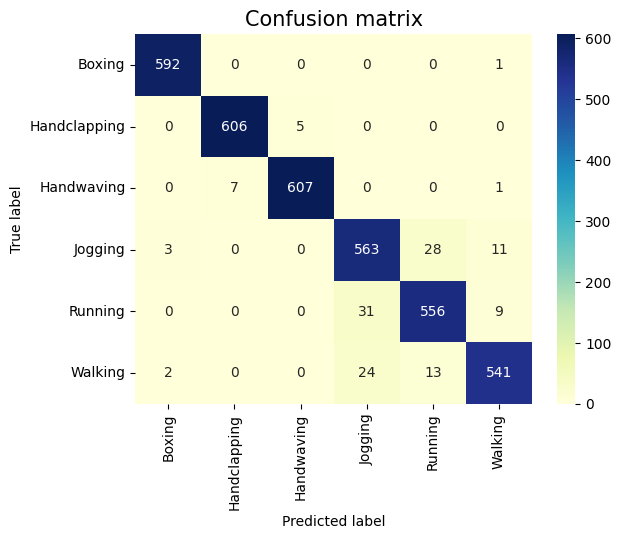

In [ ]:
from sklearn.metrics import confusion_matrix
predictions = model_final.predict(x_test)
class_label = ['Boxing', 'Handclapping', 'Handwaving', 'Jogging', 'Running', 'Walking']
max_test = np.argmax(Y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels = class_label, yticklabels = class_label, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion matrix", fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
preds = model_final.predict(x_test)
confusion_matrix = np.zeros(shape=(Y_test.shape[1],Y_test.shape[1]))
accurate_count = 0.0
for i in range(0,len(preds)):

    print ('Predicted: ', np.argmax(preds[i]), ', actual: ', np.argmax(Y_test[i]))

    # calculating overall accuracy
    if np.argmax(preds[i])==np.argmax(Y_test[i]):
        accurate_count += 1

print('Validation accuracy: ', 100*accurate_count/len(preds)),' %'
print('Confusion matrix:')
print(class_labels)
print(confusion_matrix)

113/113 [==============================] - 3s 28ms/step
Predicted:  0 , actual:  0
Predicted:  2 , actual:  2
Predicted:  3 , actual:  3
Predicted:  1 , actual:  1
Predicted:  0 , actual:  0
Predicted:  3 , actual:  3
Predicted:  0 , actual:  0
Predicted:  2 , actual:  2
Predicted:  3 , actual:  3
Predicted:  3 , actual:  3
Predicted:  5 , actual:  5
Predicted:  5 , actual:  5
Predicted:  3 , actual:  3
Predicted:  2 , actual:  2
Predicted:  0 , actual:  0
Predicted:  3 , actual:  3
Predicted:  2 , actual:  2
Predicted:  1 , actual:  1
Predicted:  1 , actual:  1
Predicted:  4 , actual:  3
Predicted:  4 , actual:  4
Predicted:  0 , actual:  0
Predicted:  2 , actual:  2
Predicted:  1 , actual:  1
Predicted:  0 , actual:  0
Predicted:  3 , actual:  3
Predicted:  4 , actual:  4
Predicted:  5 , actual:  5
Predicted:  4 , actual:  4
Predicted:  4 , actual:  4
Predicted:  2 , actual:  2
Predicted:  2 , actual:  2
Predicted:  5 , actual:  5
Predicted:  0 , actual:  0
Predicted:  5 , actual:  5

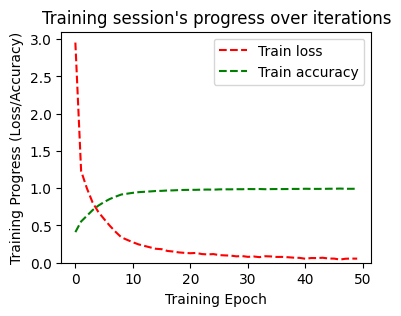

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
# plt.plot(np.array(history.history['val_loss']), "g--", label = "Validation loss")
# plt.plot(np.array(history.history['val_accuracy']), "orange", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='upper right')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

In [ ]:
loss, accuracy = model_final.evaluate(x_test, Y_test, batch_size = 20, verbose = 1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

180/180 [==============================] - 5s 18ms/step - loss: 0.1780 - accuracy: 0.9625
Test Accuracy : 0.9624999761581421
Test Loss : 0.17798475921154022
